# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


<div style = "color: Black; display: fill;
              border-radius: 7px;
              background-color: #607EAA;
              font-size: 160%;
              font-family: Verdana">
    <p style = "padding: 15px; color: White;"><b>Table of Contents

* [1. Loading Libraries and Data](#1.-Loading-Libraries-and-Data)
* [2. Data Wrangling](#2.-Data-Wrangling)
* [3. Data Exploration](#3.-Data-Exploration)
* [4. Model Building](#4.-Model-Building)
* [5. Hyperparameter Tuning](#5.-Hyperparameter-Tuning)
* [5. Conclusion](#5.-Conclusion)

## 1. Importing libraries and Data

In [26]:
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from time import sleep
from tqdm import tqdm
import scipy
from scipy import stats
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text
from statsmodels.stats.weightstats import DescrStatsW

sns.set()
%matplotlib inline
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [27]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [28]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [29]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


## 2. Data Wrangling 

In [30]:
# function to check duplicates
def check_duplicates(df):
    for col in df.columns:
        if type(df[col][0]) is not list and type(df[col][0]) is not dict:
            print('{} duplicates: {}'.format(col, df.duplicated(col).sum()))

In [31]:
# function to check null values
def check_null(df):
    total = len(df)
    for col in df.columns:
        nan_rows = df[col].isnull().sum()
        print('{} has {} % of null values'.format(col, (nan_rows/total)*100))

In [32]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [33]:
len(portfolio)

10

In [34]:
check_duplicates(portfolio)

reward duplicates: 5
difficulty duplicates: 5
duration duplicates: 5
offer_type duplicates: 7
id duplicates: 0


In [35]:
check_null(portfolio)

reward has 0.0 % of null values
channels has 0.0 % of null values
difficulty has 0.0 % of null values
duration has 0.0 % of null values
offer_type has 0.0 % of null values
id has 0.0 % of null values


In [36]:
len(portfolio.id.unique())

10

In [37]:
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

**There are no duplicate id, no null values.<br> 
Total 10 portfolio exist with following offer type: 
4 of bogo, 4 of discount and 3 of informational.**

In [38]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [39]:
len(profile)

17000

In [40]:
check_duplicates(profile)

gender duplicates: 16996
age duplicates: 16915
id duplicates: 0
became_member_on duplicates: 15284
income duplicates: 16908


In [41]:
check_null(profile)

gender has 12.794117647058822 % of null values
age has 0.0 % of null values
id has 0.0 % of null values
became_member_on has 0.0 % of null values
income has 12.794117647058822 % of null values


In [42]:
len(profile.id.unique())

17000

In [43]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [44]:
len(transcript)

306534

In [45]:
check_duplicates(transcript)

person duplicates: 289534
event duplicates: 306530
time duplicates: 306414


In [46]:
len(transcript.person.unique())

17000

In [47]:
check_null(transcript)

person has 0.0 % of null values
event has 0.0 % of null values
value has 0.0 % of null values
time has 0.0 % of null values


In [48]:
profile = profile.rename(columns = {'id':'customer_id'})

In [49]:
profile.head(1)

,gender,age,customer_id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN


In [50]:
transcript = transcript.rename(columns = {'person':'customer_id'})

In [51]:
transcript.head(1)

,customer_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0


In [52]:
temp_comb = pd.merge(profile, transcript, on='customer_id')

In [53]:
temp_comb.head()

,gender,age,customer_id,became_member_on,income,event,value,time
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},168
1,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,offer viewed,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},216
2,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},336
3,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,offer viewed,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},348
4,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,transaction,{'amount': 0.35000000000000003},360


In [54]:
check_duplicates(temp_comb)

gender duplicates: 306530
age duplicates: 306449
customer_id duplicates: 289534
became_member_on duplicates: 304818
income duplicates: 306442
event duplicates: 306530
time duplicates: 306414


In [55]:
len(temp_comb)

306534

In [56]:
check_null(temp_comb)

gender has 11.017374907840566 % of null values
age has 0.0 % of null values
customer_id has 0.0 % of null values
became_member_on has 0.0 % of null values
income has 11.017374907840566 % of null values
event has 0.0 % of null values
value has 0.0 % of null values
time has 0.0 % of null values


In [57]:
len(temp_comb.customer_id.unique())

17000

In [58]:
temp_comb = temp_comb.dropna(axis=0, subset=['gender'])

In [59]:
check_null(temp_comb)

gender has 0.0 % of null values
age has 0.0 % of null values
customer_id has 0.0 % of null values
became_member_on has 0.0 % of null values
income has 0.0 % of null values
event has 0.0 % of null values
value has 0.0 % of null values
time has 0.0 % of null values


In [60]:
len(temp_comb)

272762

In [61]:
len(temp_comb.customer_id.unique())

14825

In [62]:
temp_comb.head(2)

,gender,age,customer_id,became_member_on,income,event,value,time
21,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 21.51},18
22,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 32.28},144


In [63]:
portfolio.head(2)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0


In [64]:
temp_comb.reset_index(drop=True, inplace=True)

In [65]:
temp_comb.head(2)

,gender,age,customer_id,became_member_on,income,event,value,time
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 21.51},18
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 32.28},144


In [66]:
temp_comb=pd.concat([temp_comb, temp_comb['value'].apply(pd.Series)], axis=1)

In [67]:
temp_comb.head()

,gender,age,customer_id,became_member_on,income,event,value,time,amount,offer id,offer_id,reward
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 21.51},18,21.51,NaN,NaN,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 32.28},144,32.28,NaN,NaN,NaN
2,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
3,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504,NaN,3f207df678b143eea3cee63160fa8bed,NaN,NaN
4,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 23.22},528,23.22,NaN,NaN,NaN


In [68]:
temp_comb.reward.value_counts()

5.0     11677
2.0      8914
10.0     6967
3.0      4886
Name: reward, dtype: int64

In [69]:
temp_comb['offer_id_new']=np.where(temp_comb['offer id'].isnull() & temp_comb['offer_id'].notnull(),temp_comb['offer_id'],temp_comb['offer id'])

#drop unnecessary offer_id columns
temp_comb.drop(['offer id','offer_id'],axis=1,inplace=True)

#rename offer_id column
temp_comb.rename(columns={'offer_id_new':'offer_id'},inplace=True)

In [70]:
temp_comb.head()

,gender,age,customer_id,became_member_on,income,event,value,time,amount,reward,offer_id
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 21.51},18,21.51,NaN,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 32.28},144,32.28,NaN,NaN
2,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
3,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504,NaN,NaN,3f207df678b143eea3cee63160fa8bed
4,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 23.22},528,23.22,NaN,NaN


In [71]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [72]:
temp2 = temp_comb

In [73]:
temp2.head(2)

,gender,age,customer_id,became_member_on,income,event,value,time,amount,reward,offer_id
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 21.51},18,21.51,NaN,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 32.28},144,32.28,NaN,NaN


In [74]:
portfolio = portfolio.rename(columns = {'id':'offer_id'})

In [75]:
temp2['offer_type'] = 'None'

In [76]:
temp2.head()

,gender,age,customer_id,became_member_on,income,event,value,time,amount,reward,offer_id,offer_type
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 21.51},18,21.51,NaN,NaN,None
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 32.28},144,32.28,NaN,NaN,None
2,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,None
3,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504,NaN,NaN,3f207df678b143eea3cee63160fa8bed,None
4,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 23.22},528,23.22,NaN,NaN,None


In [77]:
temp2.shape

(272762, 12)

In [78]:
portfolio_offer_id = portfolio['offer_id'].tolist()    

In [79]:
portfolio_offer_id

['ae264e3637204a6fb9bb56bc8210ddfd',
 '4d5c57ea9a6940dd891ad53e9dbe8da0',
 '3f207df678b143eea3cee63160fa8bed',
 '9b98b8c7a33c4b65b9aebfe6a799e6d9',
 '0b1e1539f2cc45b7b9fa7c272da2e1d7',
 '2298d6c36e964ae4a3e7e9706d1fb8c2',
 'fafdcd668e3743c1bb461111dcafc2a4',
 '5a8bc65990b245e5a138643cd4eb9837',
 'f19421c1d4aa40978ebb69ca19b0e20d',
 '2906b810c7d4411798c6938adc9daaa5']

In [80]:
'ae264e3637204a6fb9bb56bc8210ddfd' in portfolio_offer_id

True

In [81]:
portfolio[portfolio['offer_id']=='ae264e3637204a6fb9bb56bc8210ddfd'].index.values[0]

0

In [82]:
temp2['offer_id'].values[0]

nan

In [83]:
temp2['duration'] = 0

In [84]:
temp2['difficulty'] = 0

In [85]:
temp2['reward_new'] = 0

In [86]:
temp2.shape

(272762, 15)

In [87]:
temp2.head(2)

,gender,age,customer_id,became_member_on,income,event,value,time,amount,reward,offer_id,offer_type,duration,difficulty,reward_new
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 21.51},18,21.51,NaN,NaN,None,0,0,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 32.28},144,32.28,NaN,NaN,None,0,0,0


In [88]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [90]:
type(portfolio['channels'].values[0])

list

In [91]:
temp2.head()

,gender,age,customer_id,became_member_on,income,event,value,time,amount,reward,offer_id,offer_type,duration,difficulty,reward_new
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 21.51},18,21.51,NaN,NaN,None,0,0,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 32.28},144,32.28,NaN,NaN,None,0,0,0
2,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,None,0,0,0
3,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504,NaN,NaN,3f207df678b143eea3cee63160fa8bed,None,0,0,0
4,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 23.22},528,23.22,NaN,NaN,None,0,0,0


In [92]:
temp2['channels'] = [list() for x in range(len(temp2.index))]

In [93]:
temp2.head()

,gender,age,customer_id,became_member_on,income,event,value,time,amount,reward,offer_id,offer_type,duration,difficulty,reward_new,channels
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 21.51},18,21.51,NaN,NaN,None,0,0,0,[]
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 32.28},144,32.28,NaN,NaN,None,0,0,0,[]
2,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,None,0,0,0,[]
3,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504,NaN,NaN,3f207df678b143eea3cee63160fa8bed,None,0,0,0,[]
4,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 23.22},528,23.22,NaN,NaN,None,0,0,0,[]


In [94]:
# pbar = ProgressBar()
for row in tqdm(range(272762)):
    current_offer = temp2['offer_id'].values[row]
    if current_offer in portfolio_offer_id:
        ind = portfolio[portfolio['offer_id']==current_offer].index.values[0]
        temp2.at[row,'offer_type']= portfolio['offer_type'].values[ind]
        temp2.at[row,'duration']= portfolio['duration'].values[ind]
        temp2.at[row,'difficulty']= portfolio['difficulty'].values[ind]
        temp2.at[row,'channels']= portfolio['channels'].values[ind]
        temp2.at[row,'reward_new']= portfolio['reward'].values[ind]

100%|████████████████████████████████████████████████████████████████████████| 272762/272762 [00:46<00:00, 5870.89it/s]


In [95]:
temp2.head()

,gender,age,customer_id,became_member_on,income,event,value,time,amount,reward,offer_id,offer_type,duration,difficulty,reward_new,channels
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 21.51},18,21.51,NaN,NaN,None,0,0,0,[]
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 32.28},144,32.28,NaN,NaN,None,0,0,0,[]
2,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,7,5,5,"[web, email, mobile]"
3,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504,NaN,NaN,3f207df678b143eea3cee63160fa8bed,informational,4,0,0,"[web, email, mobile]"
4,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 23.22},528,23.22,NaN,NaN,None,0,0,0,[]


In [96]:
df = temp2

In [97]:
df.head(2)

,gender,age,customer_id,became_member_on,income,event,value,time,amount,reward,offer_id,offer_type,duration,difficulty,reward_new,channels
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 21.51},18,21.51,NaN,NaN,None,0,0,0,[]
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 32.28},144,32.28,NaN,NaN,None,0,0,0,[]


In [98]:
def encode_cat_var(dataframe, col):
    """ 
    Function to encode categorical variable to numeric in a dataframe.
    
    Parameters: 
    arg1 (int): Dataframe
    arg2 (string) : Column Name
  
    Returns: 
    tuple : Tuple containing a modified dataframe and a dictionary containing encoded mapping.
  
    """
    df = dataframe
    encoder =  LabelEncoder()
    df[col] = encoder.fit_transform(df[col])
    mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
    return (df, mapping)

In [99]:
df.dtypes

gender               object
age                   int64
customer_id          object
became_member_on      int64
income              float64
event                object
value                object
time                  int64
amount              float64
reward              float64
offer_id             object
offer_type           object
duration              int64
difficulty            int64
reward_new            int64
channels             object
dtype: object

In [100]:
cat_columns = ['gender', 'event', 'offer_type']

In [101]:
str_columns = ['customer_id', 'offer_id']

In [102]:
for col in cat_columns:
    df[col] = df[col].astype('category')

In [103]:
check_null(df)

gender has 0.0 % of null values
age has 0.0 % of null values
customer_id has 0.0 % of null values
became_member_on has 0.0 % of null values
income has 0.0 % of null values
event has 0.0 % of null values
value has 0.0 % of null values
time has 0.0 % of null values
amount has 54.55488667776304 % of null values
reward has 88.10538124812108 % of null values
offer_id has 45.44511332223697 % of null values
offer_type has 0.0 % of null values
duration has 0.0 % of null values
difficulty has 0.0 % of null values
reward_new has 0.0 % of null values
channels has 0.0 % of null values


In [104]:
df.shape

(272762, 16)

In [105]:
df.head()

,gender,age,customer_id,became_member_on,income,event,value,time,amount,reward,offer_id,offer_type,duration,difficulty,reward_new,channels
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 21.51},18,21.51,NaN,NaN,None,0,0,0,[]
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 32.28},144,32.28,NaN,NaN,None,0,0,0,[]
2,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,7,5,5,"[web, email, mobile]"
3,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504,NaN,NaN,3f207df678b143eea3cee63160fa8bed,informational,4,0,0,"[web, email, mobile]"
4,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 23.22},528,23.22,NaN,NaN,None,0,0,0,[]


In [106]:
df.amount.fillna(value=0, inplace=True)

In [107]:
df.reward.fillna(value=0, inplace=True)

In [108]:
df.offer_id.fillna(value=0, inplace=True)

In [109]:
df.shape

(272762, 16)

In [110]:
del df['reward']

In [111]:
df.rename(columns={'reward_new':'reward'},inplace=True)

In [112]:
check_null(df)

gender has 0.0 % of null values
age has 0.0 % of null values
customer_id has 0.0 % of null values
became_member_on has 0.0 % of null values
income has 0.0 % of null values
event has 0.0 % of null values
value has 0.0 % of null values
time has 0.0 % of null values
amount has 0.0 % of null values
offer_id has 0.0 % of null values
offer_type has 0.0 % of null values
duration has 0.0 % of null values
difficulty has 0.0 % of null values
reward has 0.0 % of null values
channels has 0.0 % of null values


In [113]:
df.shape

(272762, 15)

In [114]:
df, gender_mapping = encode_cat_var(df, 'gender')
print(gender_mapping)

{'F': 0, 'M': 1, 'O': 2}


In [115]:
df, event_mapping = encode_cat_var(df, 'event')
print(event_mapping)

{'offer completed': 0, 'offer received': 1, 'offer viewed': 2, 'transaction': 3}


In [116]:
df.dtypes

gender                 int32
age                    int64
customer_id           object
became_member_on       int64
income               float64
event                  int32
value                 object
time                   int64
amount               float64
offer_id              object
offer_type          category
duration               int64
difficulty             int64
reward                 int64
channels              object
dtype: object

In [117]:
df['offer_id'] = df['offer_id'].apply(str)

In [118]:
df, offer_id_mapping = encode_cat_var(df, 'offer_id')
print(offer_id_mapping)

{'0': 0, '0b1e1539f2cc45b7b9fa7c272da2e1d7': 1, '2298d6c36e964ae4a3e7e9706d1fb8c2': 2, '2906b810c7d4411798c6938adc9daaa5': 3, '3f207df678b143eea3cee63160fa8bed': 4, '4d5c57ea9a6940dd891ad53e9dbe8da0': 5, '5a8bc65990b245e5a138643cd4eb9837': 6, '9b98b8c7a33c4b65b9aebfe6a799e6d9': 7, 'ae264e3637204a6fb9bb56bc8210ddfd': 8, 'f19421c1d4aa40978ebb69ca19b0e20d': 9, 'fafdcd668e3743c1bb461111dcafc2a4': 10}


In [119]:
df, offer_type_mapping = encode_cat_var(df, 'offer_type')
print(offer_type_mapping)

{'None': 0, 'bogo': 1, 'discount': 2, 'informational': 3}


In [120]:
del df['value']

In [121]:
df.head(2)

,gender,age,customer_id,became_member_on,income,event,time,amount,offer_id,offer_type,duration,difficulty,reward,channels
0,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,3,18,21.51,0,0,0,0,0,[]
1,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,3,144,32.28,0,0,0,0,0,[]


In [122]:
channels = df["channels"].str.join(sep="*").str.get_dummies(sep="*")

In [123]:
df = pd.concat([df, channels], axis=1, sort=False)

In [124]:
del df['channels']

In [125]:
df.head()

,gender,age,customer_id,became_member_on,income,event,time,amount,offer_id,offer_type,duration,difficulty,reward,email,mobile,social,web
0,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,3,18,21.51,0,0,0,0,0,0,0,0,0
1,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,3,144,32.28,0,0,0,0,0,0,0,0,0
2,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1,408,0.00,7,1,7,5,5,1,1,0,1
3,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1,504,0.00,4,3,4,0,0,1,1,0,1
4,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,3,528,23.22,0,0,0,0,0,0,0,0,0


In [126]:
len(df.groupby('customer_id'))

14825

In [127]:
len(df['customer_id'].unique())

14825

In [128]:
offer_type_mapping

{'None': 0, 'bogo': 1, 'discount': 2, 'informational': 3}

In [129]:
df.shape

(272762, 17)

In [130]:
check_null(df)

gender has 0.0 % of null values
age has 0.0 % of null values
customer_id has 0.0 % of null values
became_member_on has 0.0 % of null values
income has 0.0 % of null values
event has 0.0 % of null values
time has 0.0 % of null values
amount has 0.0 % of null values
offer_id has 0.0 % of null values
offer_type has 0.0 % of null values
duration has 0.0 % of null values
difficulty has 0.0 % of null values
reward has 0.0 % of null values
email has 0.0 % of null values
mobile has 0.0 % of null values
social has 0.0 % of null values
web has 0.0 % of null values


In [131]:
df['respond_to_offer'] = 0

In [132]:
df.shape

(272762, 18)

In [133]:
df.head()

,gender,age,customer_id,became_member_on,income,event,time,amount,offer_id,offer_type,duration,difficulty,reward,email,mobile,social,web,respond_to_offer
0,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,3,18,21.51,0,0,0,0,0,0,0,0,0,0
1,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,3,144,32.28,0,0,0,0,0,0,0,0,0,0
2,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1,408,0.00,7,1,7,5,5,1,1,0,1,0
3,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1,504,0.00,4,3,4,0,0,1,1,0,1,0
4,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,3,528,23.22,0,0,0,0,0,0,0,0,0,0


In [134]:
df.head(10)

,gender,age,customer_id,became_member_on,income,event,time,amount,offer_id,offer_type,duration,difficulty,reward,email,mobile,social,web,respond_to_offer
0,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,3,18,21.51,0,0,0,0,0,0,0,0,0,0
1,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,3,144,32.28,0,0,0,0,0,0,0,0,0,0
2,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1,408,0.00,7,1,7,5,5,1,1,0,1,0
3,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1,504,0.00,4,3,4,0,0,1,1,0,1,0
4,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,3,528,23.22,0,0,0,0,0,0,0,0,0,0
5,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,0,528,0.00,7,1,7,5,5,1,1,0,1,0
6,0,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,1,0,0.00,7,1,7,5,5,1,1,0,1,0
7,0,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2,6,0.00,7,1,7,5,5,1,1,0,1,0
8,0,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,3,132,19.89,0,0,0,0,0,0,0,0,0,0
9,0,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,0,132,0.00,7,1,7,5,5,1,1,0,1,0


In [135]:
df.to_csv('data/combined.csv', encoding='utf-8', index=False)

In [136]:
df = pd.read_csv('data/combined.csv')

In [137]:
def plot_distplot(df, col):
    mean = scipy.mean(df[col])
    median = scipy.median(df[col])
    plt.figure(figsize=(8,8))
    sns.distplot(df[col])
    plt.axvline(mean, color='r',label='mean')
    plt.axvline(median, color='b',label='median')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [138]:
df.head()

,gender,age,customer_id,became_member_on,income,event,time,amount,offer_id,offer_type,duration,difficulty,reward,email,mobile,social,web,respond_to_offer
0,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,3,18,21.51,0,0,0,0,0,0,0,0,0,0
1,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,3,144,32.28,0,0,0,0,0,0,0,0,0,0
2,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1,408,0.00,7,1,7,5,5,1,1,0,1,0
3,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1,504,0.00,4,3,4,0,0,1,1,0,1,0
4,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,3,528,23.22,0,0,0,0,0,0,0,0,0,0


In [139]:
check_null(df)

gender has 0.0 % of null values
age has 0.0 % of null values
customer_id has 0.0 % of null values
became_member_on has 0.0 % of null values
income has 0.0 % of null values
event has 0.0 % of null values
time has 0.0 % of null values
amount has 0.0 % of null values
offer_id has 0.0 % of null values
offer_type has 0.0 % of null values
duration has 0.0 % of null values
difficulty has 0.0 % of null values
reward has 0.0 % of null values
email has 0.0 % of null values
mobile has 0.0 % of null values
social has 0.0 % of null values
web has 0.0 % of null values
respond_to_offer has 0.0 % of null values


In [140]:
df['age'].describe()

count    272762.000000
mean         53.840696
std          17.551337
min          18.000000
25%          41.000000
50%          55.000000
75%          66.000000
max         101.000000
Name: age, dtype: float64

C:\Users\joefi\AppData\Local\Temp\ipykernel_21140\3548733187.py:2: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  mean = scipy.mean(df[col])
C:\Users\joefi\AppData\Local\Temp\ipykernel_21140\3548733187.py:3: DeprecationWarning: scipy.median is deprecated and will be removed in SciPy 2.0.0, use numpy.median instead
  median = scipy.median(df[col])


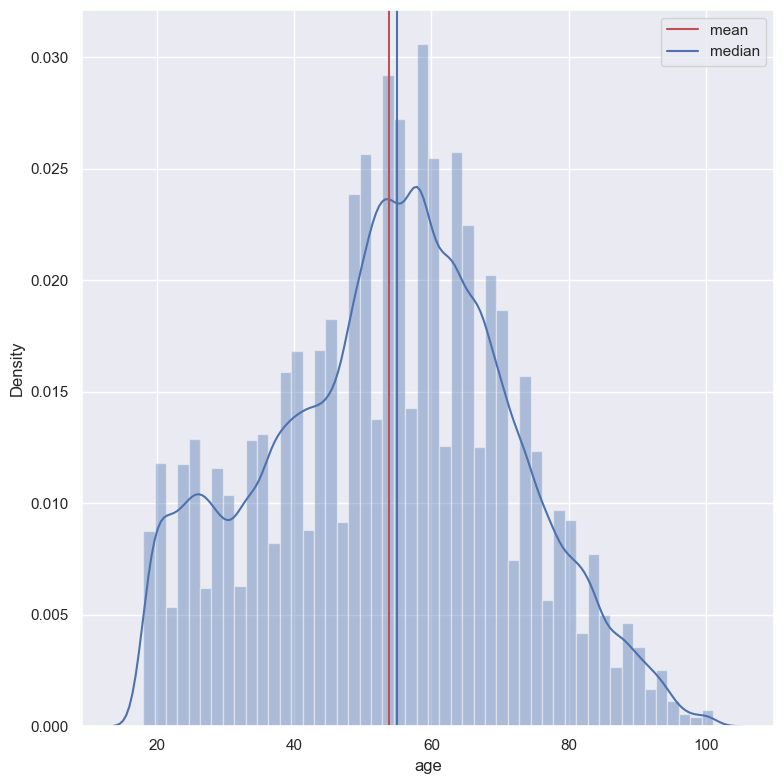

In [141]:
plot_distplot(df, 'age')

**There are total 84 different ages, so binning them.**

In [142]:
age_bins = [0,10,20,30,40,50,60,70,80,90,100,110]
age_labels = [1,2,3,4,5,6,7,8,9,10,11]
df['binned_age'] = pd.cut(df['age'], bins=age_bins, labels=age_labels)

In [143]:
del df['age']

In [144]:
df.head(2)

,gender,customer_id,became_member_on,income,event,time,amount,offer_id,offer_type,duration,difficulty,reward,email,mobile,social,web,respond_to_offer,binned_age
0,0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,3,18,21.51,0,0,0,0,0,0,0,0,0,0,6
1,0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,3,144,32.28,0,0,0,0,0,0,0,0,0,0,6


In [145]:
from datetime import datetime
def convert_to_datetime(elem):
    """Converts a string to a datetime object
    
    INPUT:
        elem: String that stores a date in the %Y%m%d format
    OUTPUT:
        datetimeobj: Datetime object"""
    return datetime.strptime(str(elem), '%Y%m%d')

In [146]:
df['date'] = df['became_member_on'].apply(convert_to_datetime)

In [147]:
df.head()

,gender,customer_id,became_member_on,income,event,time,amount,offer_id,offer_type,duration,difficulty,reward,email,mobile,social,web,respond_to_offer,binned_age,date
0,0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,3,18,21.51,0,0,0,0,0,0,0,0,0,0,6,2017-07-15
1,0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,3,144,32.28,0,0,0,0,0,0,0,0,0,0,6,2017-07-15
2,0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1,408,0.00,7,1,7,5,5,1,1,0,1,0,6,2017-07-15
3,0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1,504,0.00,4,3,4,0,0,1,1,0,1,0,6,2017-07-15
4,0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,3,528,23.22,0,0,0,0,0,0,0,0,0,0,6,2017-07-15


In [148]:
del df['became_member_on']

In [149]:
df['income'].describe()

count    272762.000000
mean      64337.000755
std       21243.762941
min       30000.000000
25%       48000.000000
50%       62000.000000
75%       78000.000000
max      120000.000000
Name: income, dtype: float64

**Binning income**

C:\Users\joefi\AppData\Local\Temp\ipykernel_21140\3548733187.py:2: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  mean = scipy.mean(df[col])
C:\Users\joefi\AppData\Local\Temp\ipykernel_21140\3548733187.py:3: DeprecationWarning: scipy.median is deprecated and will be removed in SciPy 2.0.0, use numpy.median instead
  median = scipy.median(df[col])


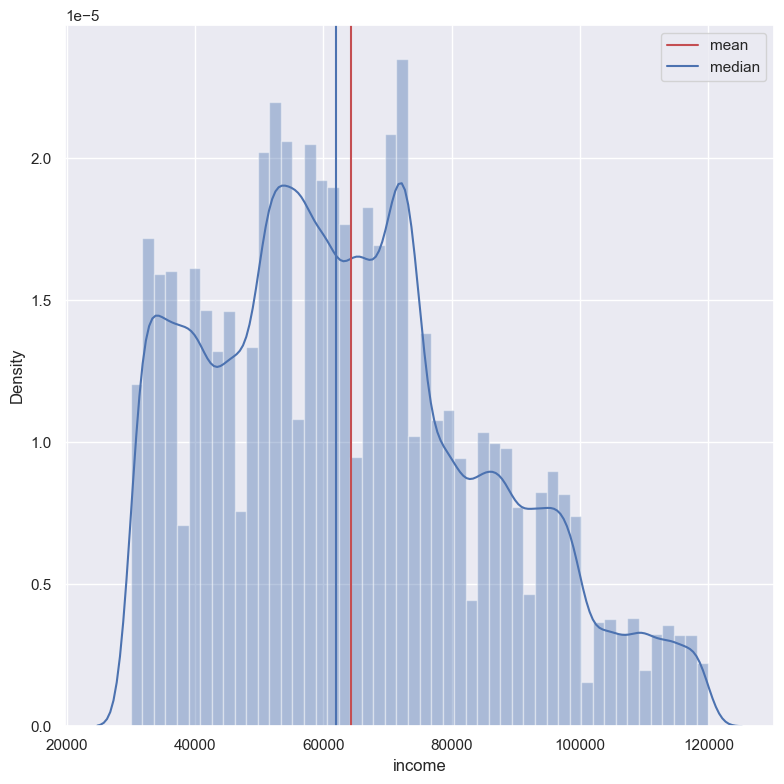

In [150]:
plot_distplot(df, 'income')

In [151]:
income_bins = [10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000,130000]
income_labels = [2,3,4,5,6,7,8,9,10,11,12,13]
df['binned_income'] = pd.cut(df['income'], bins=income_bins, labels=income_labels)

In [152]:
del df['income']

In [153]:
df.time.describe()

count    272762.000000
mean        366.707694
std         200.359087
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64

C:\Users\joefi\AppData\Local\Temp\ipykernel_21140\3548733187.py:2: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  mean = scipy.mean(df[col])
C:\Users\joefi\AppData\Local\Temp\ipykernel_21140\3548733187.py:3: DeprecationWarning: scipy.median is deprecated and will be removed in SciPy 2.0.0, use numpy.median instead
  median = scipy.median(df[col])


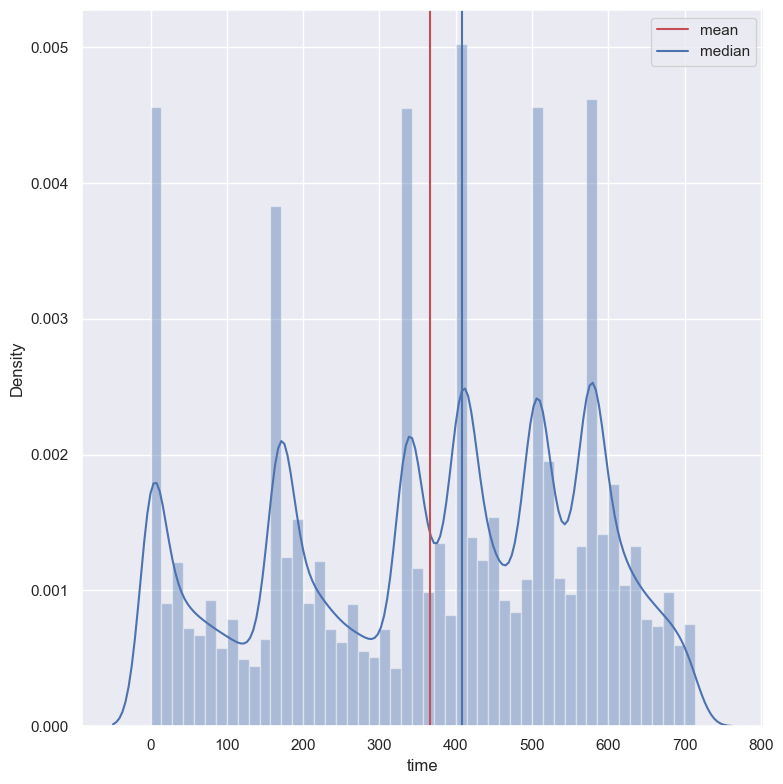

In [154]:
plot_distplot(df, 'time')

In [155]:
check_null(df)

gender has 0.0 % of null values
customer_id has 0.0 % of null values
event has 0.0 % of null values
time has 0.0 % of null values
amount has 0.0 % of null values
offer_id has 0.0 % of null values
offer_type has 0.0 % of null values
duration has 0.0 % of null values
difficulty has 0.0 % of null values
reward has 0.0 % of null values
email has 0.0 % of null values
mobile has 0.0 % of null values
social has 0.0 % of null values
web has 0.0 % of null values
respond_to_offer has 0.0 % of null values
binned_age has 0.0 % of null values
date has 0.0 % of null values
binned_income has 0.0 % of null values


In [156]:
df.amount.describe()

count    272762.000000
mean          6.360646
std          22.509207
min           0.000000
25%           0.000000
50%           0.000000
75%           9.140000
max        1062.280000
Name: amount, dtype: float64

C:\Users\joefi\AppData\Local\Temp\ipykernel_21140\3548733187.py:2: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  mean = scipy.mean(df[col])
C:\Users\joefi\AppData\Local\Temp\ipykernel_21140\3548733187.py:3: DeprecationWarning: scipy.median is deprecated and will be removed in SciPy 2.0.0, use numpy.median instead
  median = scipy.median(df[col])


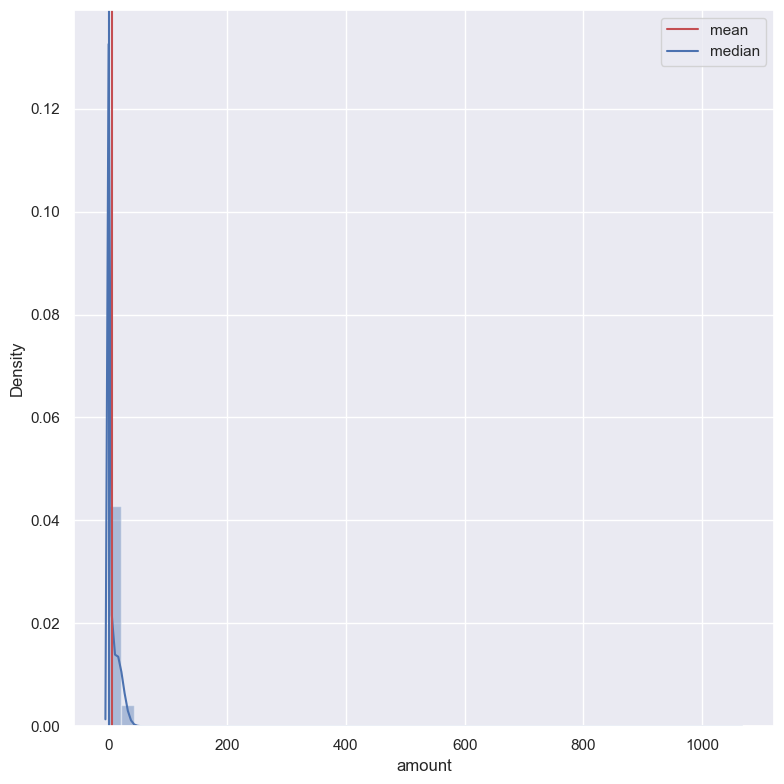

In [157]:
plot_distplot(df,'amount')

In [158]:
q = df["amount"].quantile(0.99)

In [159]:
df = df[df["amount"] < q]

In [160]:
df.shape

(270033, 18)

In [161]:
df.amount.describe()

count    270033.000000
mean          5.311545
std           8.421955
min           0.000000
25%           0.000000
50%           0.000000
75%           8.580000
max          35.340000
Name: amount, dtype: float64

C:\Users\joefi\AppData\Local\Temp\ipykernel_21140\3548733187.py:2: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  mean = scipy.mean(df[col])
C:\Users\joefi\AppData\Local\Temp\ipykernel_21140\3548733187.py:3: DeprecationWarning: scipy.median is deprecated and will be removed in SciPy 2.0.0, use numpy.median instead
  median = scipy.median(df[col])


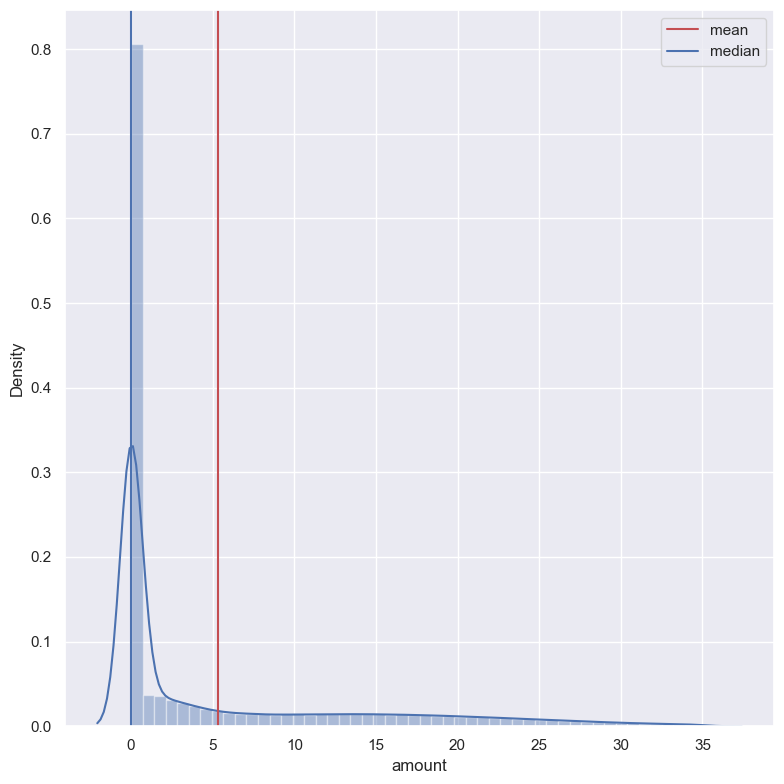

In [162]:
plot_distplot(df, 'amount')

In [163]:
check_null(df)

gender has 0.0 % of null values
customer_id has 0.0 % of null values
event has 0.0 % of null values
time has 0.0 % of null values
amount has 0.0 % of null values
offer_id has 0.0 % of null values
offer_type has 0.0 % of null values
duration has 0.0 % of null values
difficulty has 0.0 % of null values
reward has 0.0 % of null values
email has 0.0 % of null values
mobile has 0.0 % of null values
social has 0.0 % of null values
web has 0.0 % of null values
respond_to_offer has 0.0 % of null values
binned_age has 0.0 % of null values
date has 0.0 % of null values
binned_income has 0.0 % of null values


In [164]:
df.head()

,gender,customer_id,event,time,amount,offer_id,offer_type,duration,difficulty,reward,email,mobile,social,web,respond_to_offer,binned_age,date,binned_income
0,0,0610b486422d4921ae7d2bf64640c50b,3,18,21.51,0,0,0,0,0,0,0,0,0,0,6,2017-07-15,12
1,0,0610b486422d4921ae7d2bf64640c50b,3,144,32.28,0,0,0,0,0,0,0,0,0,0,6,2017-07-15,12
2,0,0610b486422d4921ae7d2bf64640c50b,1,408,0.00,7,1,7,5,5,1,1,0,1,0,6,2017-07-15,12
3,0,0610b486422d4921ae7d2bf64640c50b,1,504,0.00,4,3,4,0,0,1,1,0,1,0,6,2017-07-15,12
4,0,0610b486422d4921ae7d2bf64640c50b,3,528,23.22,0,0,0,0,0,0,0,0,0,0,6,2017-07-15,12


In [165]:
df['year'] = pd.DatetimeIndex(df['date']).year

In [166]:
df['month'] = pd.DatetimeIndex(df['date']).month

In [167]:
df.head()

,gender,customer_id,event,time,amount,offer_id,offer_type,duration,difficulty,reward,email,mobile,social,web,respond_to_offer,binned_age,date,binned_income,year,month
0,0,0610b486422d4921ae7d2bf64640c50b,3,18,21.51,0,0,0,0,0,0,0,0,0,0,6,2017-07-15,12,2017,7
1,0,0610b486422d4921ae7d2bf64640c50b,3,144,32.28,0,0,0,0,0,0,0,0,0,0,6,2017-07-15,12,2017,7
2,0,0610b486422d4921ae7d2bf64640c50b,1,408,0.00,7,1,7,5,5,1,1,0,1,0,6,2017-07-15,12,2017,7
3,0,0610b486422d4921ae7d2bf64640c50b,1,504,0.00,4,3,4,0,0,1,1,0,1,0,6,2017-07-15,12,2017,7
4,0,0610b486422d4921ae7d2bf64640c50b,3,528,23.22,0,0,0,0,0,0,0,0,0,0,6,2017-07-15,12,2017,7


In [168]:
del df['date']

In [169]:
df.head()

,gender,customer_id,event,time,amount,offer_id,offer_type,duration,difficulty,reward,email,mobile,social,web,respond_to_offer,binned_age,binned_income,year,month
0,0,0610b486422d4921ae7d2bf64640c50b,3,18,21.51,0,0,0,0,0,0,0,0,0,0,6,12,2017,7
1,0,0610b486422d4921ae7d2bf64640c50b,3,144,32.28,0,0,0,0,0,0,0,0,0,0,6,12,2017,7
2,0,0610b486422d4921ae7d2bf64640c50b,1,408,0.00,7,1,7,5,5,1,1,0,1,0,6,12,2017,7
3,0,0610b486422d4921ae7d2bf64640c50b,1,504,0.00,4,3,4,0,0,1,1,0,1,0,6,12,2017,7
4,0,0610b486422d4921ae7d2bf64640c50b,3,528,23.22,0,0,0,0,0,0,0,0,0,0,6,12,2017,7


**Saving dataframe**

In [170]:
df.to_csv('data/clean.csv', encoding='utf-8', index=False)

## 3. Data Exploration

In [171]:
quant_columns = ['time', 'amount']
mapped_columns = ['gender', 'event', 'offer_id', 'offer_type']

In [172]:
non_mapped_columns = ['duration', 'difficulty', 'reward', 'email', 'mobile', 'social', 'web',
                      'binned_age', 'binned_income', 'year', 'month', 'respond_to_offer']

C:\Users\joefi\AppData\Local\Temp\ipykernel_21140\3548733187.py:2: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  mean = scipy.mean(df[col])
C:\Users\joefi\AppData\Local\Temp\ipykernel_21140\3548733187.py:3: DeprecationWarning: scipy.median is deprecated and will be removed in SciPy 2.0.0, use numpy.median instead
  median = scipy.median(df[col])


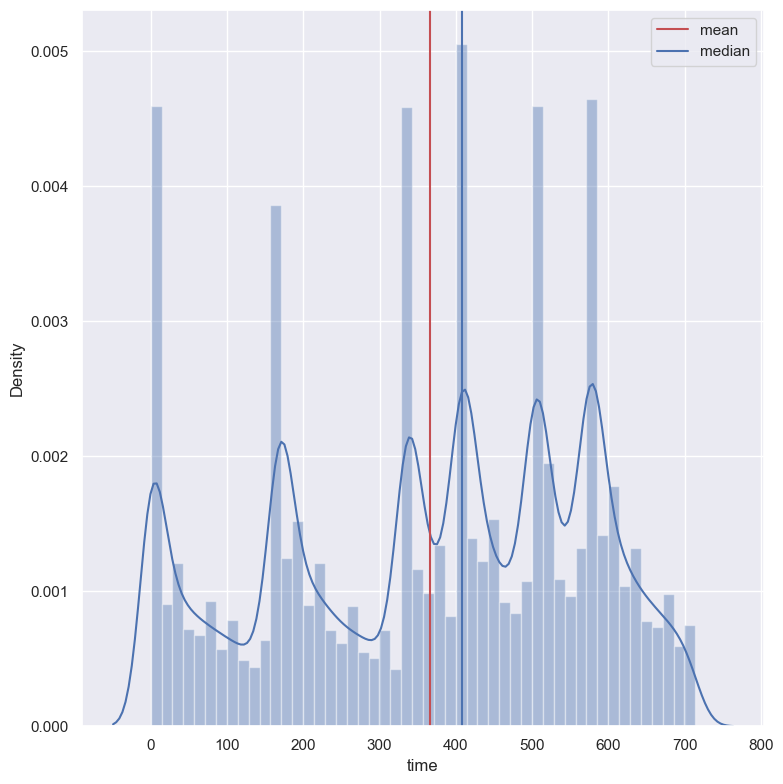

C:\Users\joefi\AppData\Local\Temp\ipykernel_21140\3548733187.py:2: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  mean = scipy.mean(df[col])
C:\Users\joefi\AppData\Local\Temp\ipykernel_21140\3548733187.py:3: DeprecationWarning: scipy.median is deprecated and will be removed in SciPy 2.0.0, use numpy.median instead
  median = scipy.median(df[col])


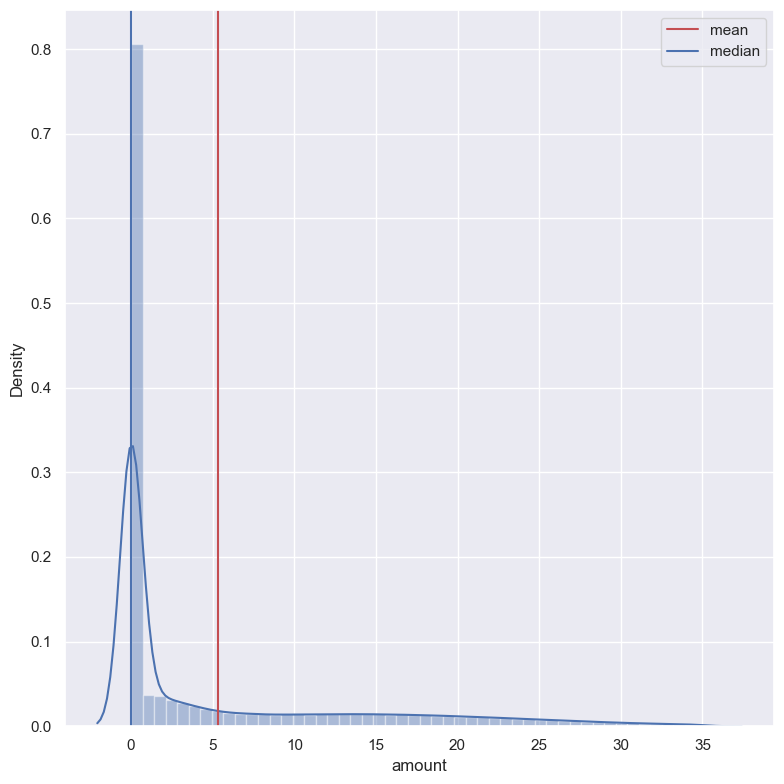

In [173]:
for col in quant_columns:
    plot_distplot(df, col)

**Insights: amount has some outlier.**

In [174]:
def count_plot_legend(df, col, mapping):
    class TextHandler(HandlerBase):
        def create_artists(self, legend, tup ,xdescent, ydescent,
                            width, height, fontsize,trans):
            tx = Text(width/2.,height/2,tup[0], fontsize=fontsize,
                      ha="center", va="center", color=tup[1], fontweight="bold")
            return [tx]



    base_color = sns.color_palette()[0]
    ax = sns.countplot(x = df[col], color= base_color)


    handltext = list(mapping.values())
    handltext = list(map(str, handltext))
    labels = list(mapping.keys())


    t = ax.get_xticklabels()
    labeldic = dict(zip(handltext, labels))
    labels = [labeldic[h.get_text()]  for h in t]
    handles = [(h.get_text(),c.get_fc()) for h,c in zip(t,ax.patches)]

    ax.legend(handles, labels, handler_map={tuple : TextHandler()}) 

    plt.tight_layout()
    plt.show()

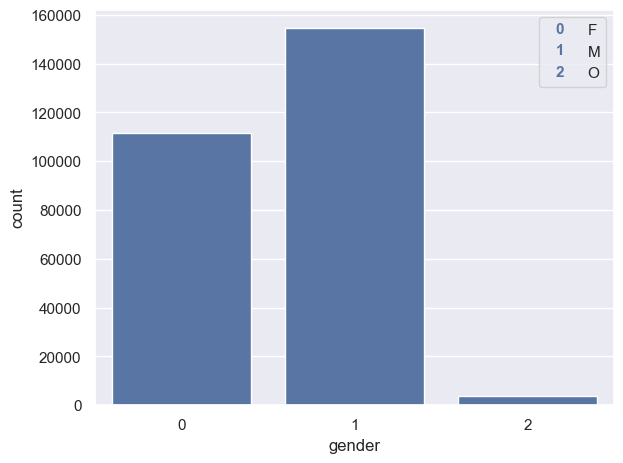

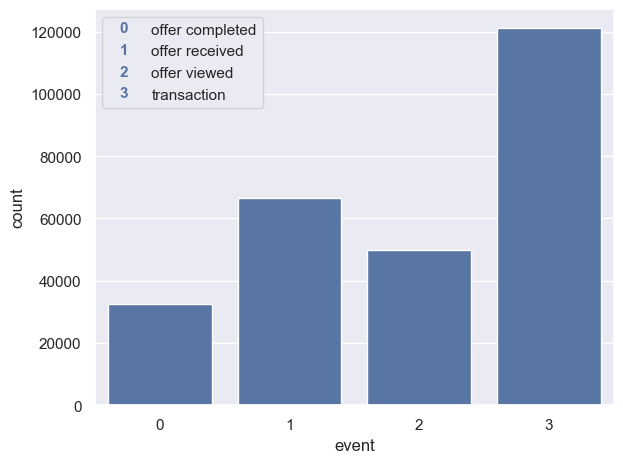

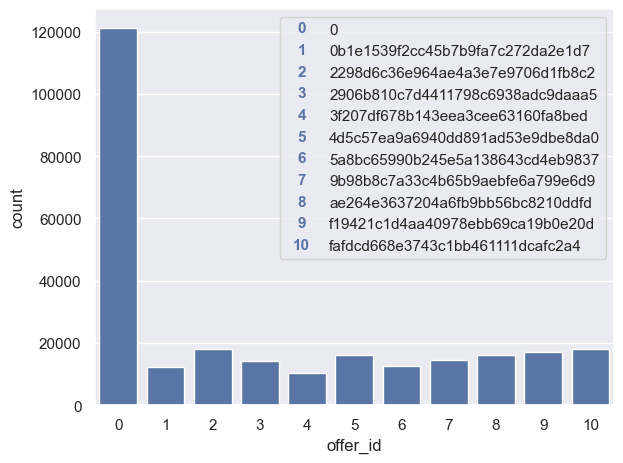

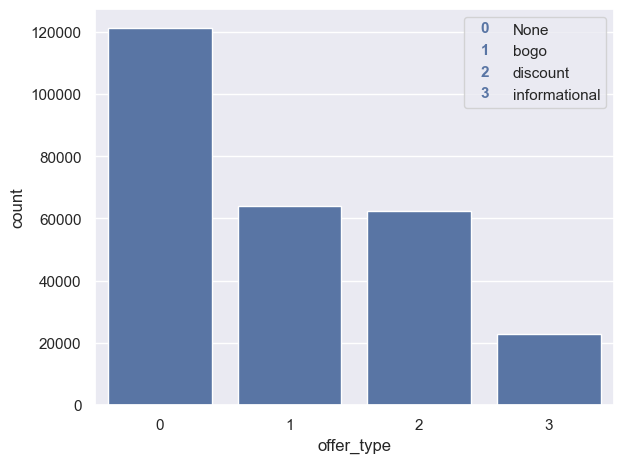

In [175]:
for col in mapped_columns:
    m = col + '_mapping'
    mapping = globals()[m]
    count_plot_legend(df,col ,mapping)

**Insight: Very few people respond to offer, that is, completes the offer.**

In [176]:
df.head()

,gender,customer_id,event,time,amount,offer_id,offer_type,duration,difficulty,reward,email,mobile,social,web,respond_to_offer,binned_age,binned_income,year,month
0,0,0610b486422d4921ae7d2bf64640c50b,3,18,21.51,0,0,0,0,0,0,0,0,0,0,6,12,2017,7
1,0,0610b486422d4921ae7d2bf64640c50b,3,144,32.28,0,0,0,0,0,0,0,0,0,0,6,12,2017,7
2,0,0610b486422d4921ae7d2bf64640c50b,1,408,0.00,7,1,7,5,5,1,1,0,1,0,6,12,2017,7
3,0,0610b486422d4921ae7d2bf64640c50b,1,504,0.00,4,3,4,0,0,1,1,0,1,0,6,12,2017,7
4,0,0610b486422d4921ae7d2bf64640c50b,3,528,23.22,0,0,0,0,0,0,0,0,0,0,6,12,2017,7


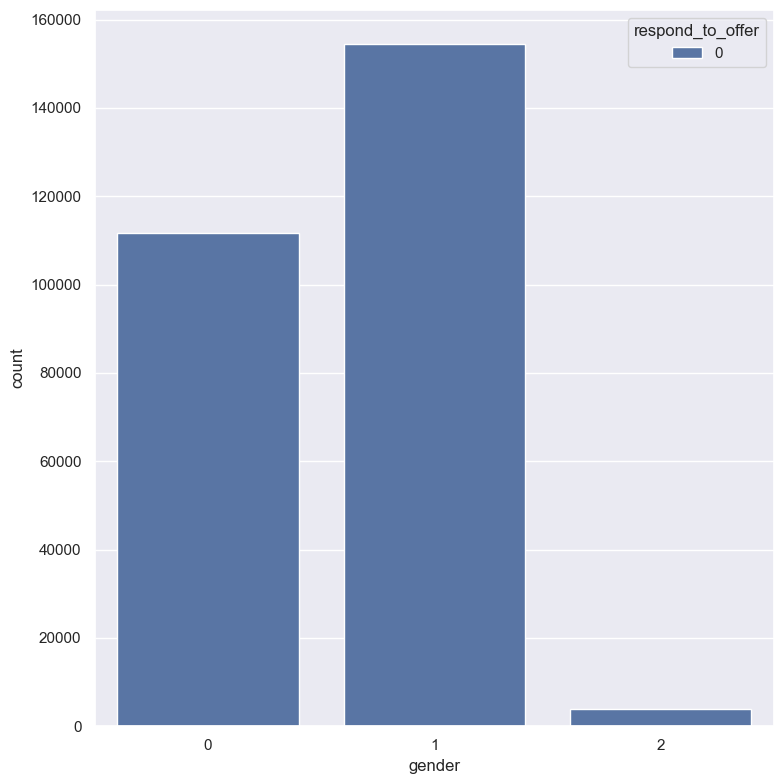

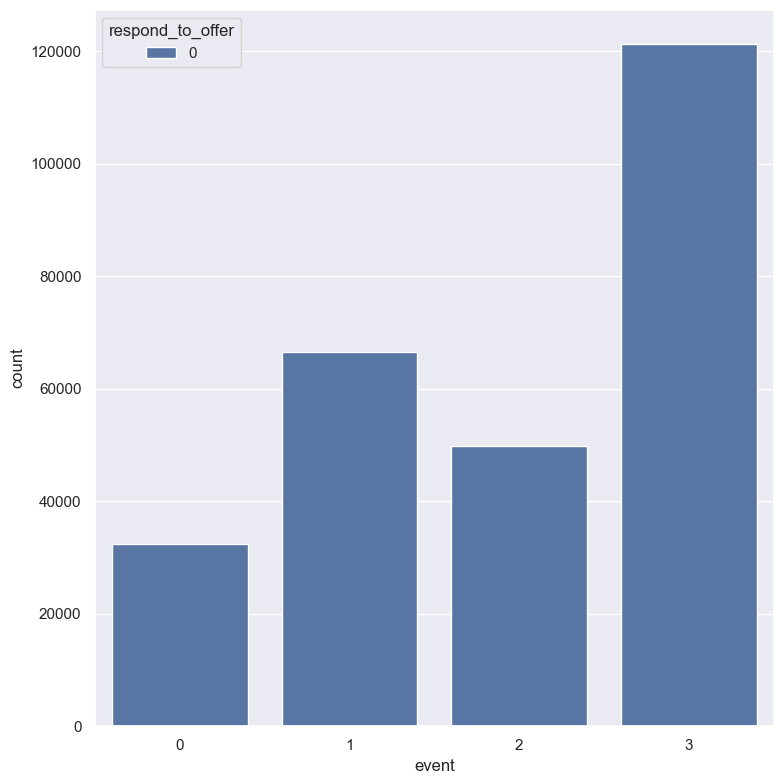

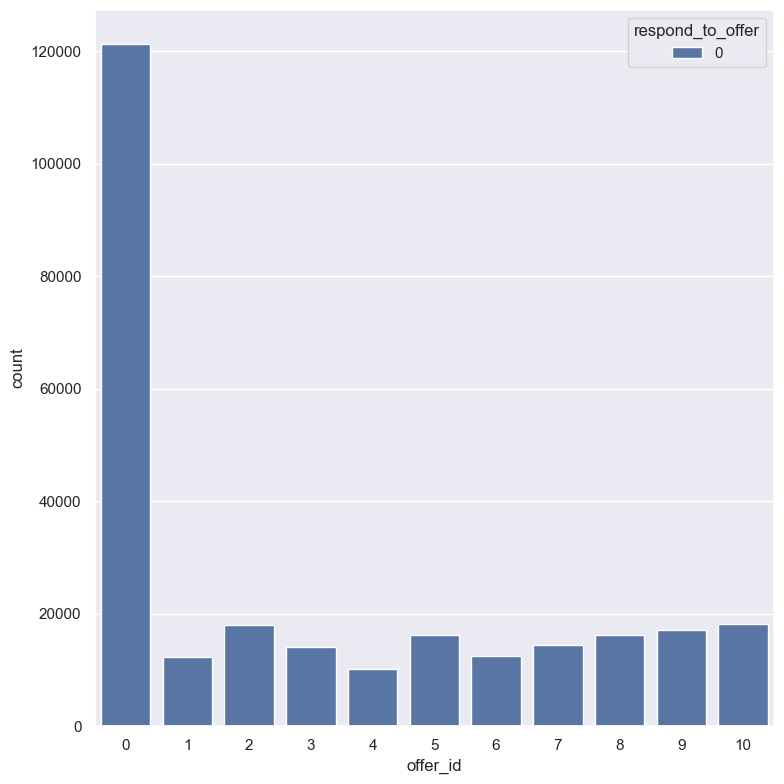

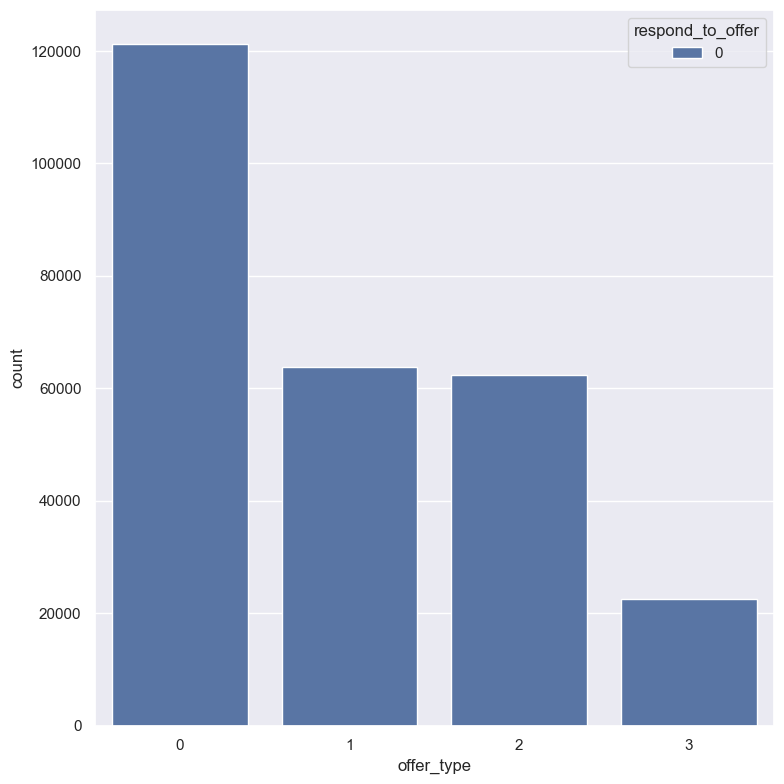

In [177]:
for var in mapped_columns:
    temp = df.groupby([var,'respond_to_offer']).size()
    plt.figure(figsize=(8,8))
    sns.countplot(data=df,x=var,hue='respond_to_offer')
    plt.tight_layout()
    plt.show()

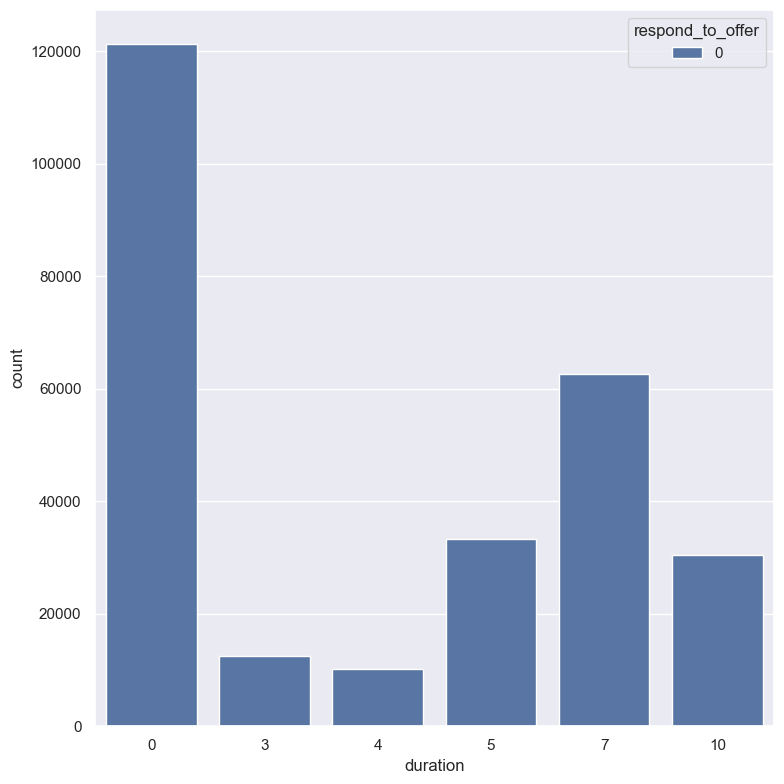

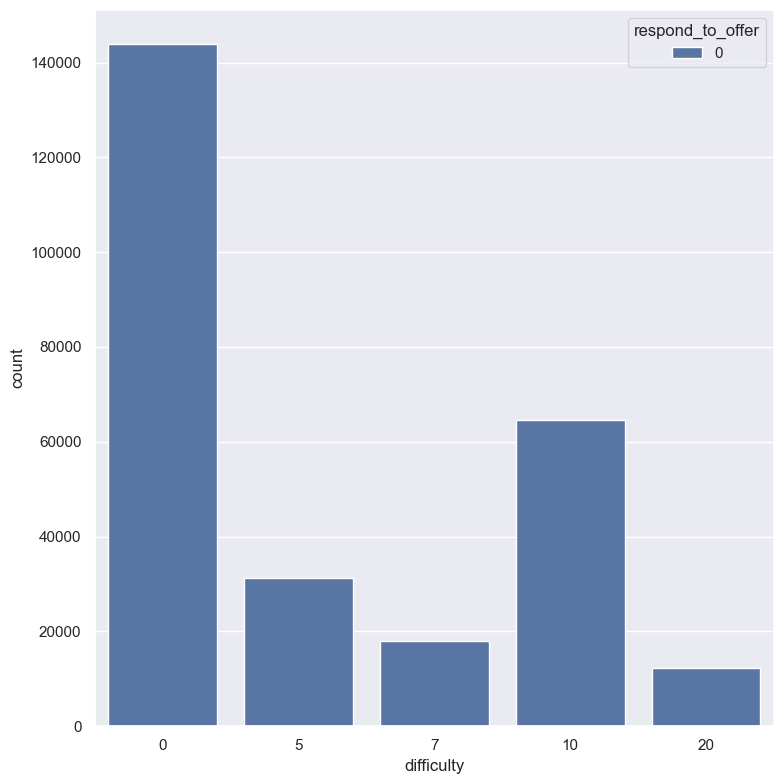

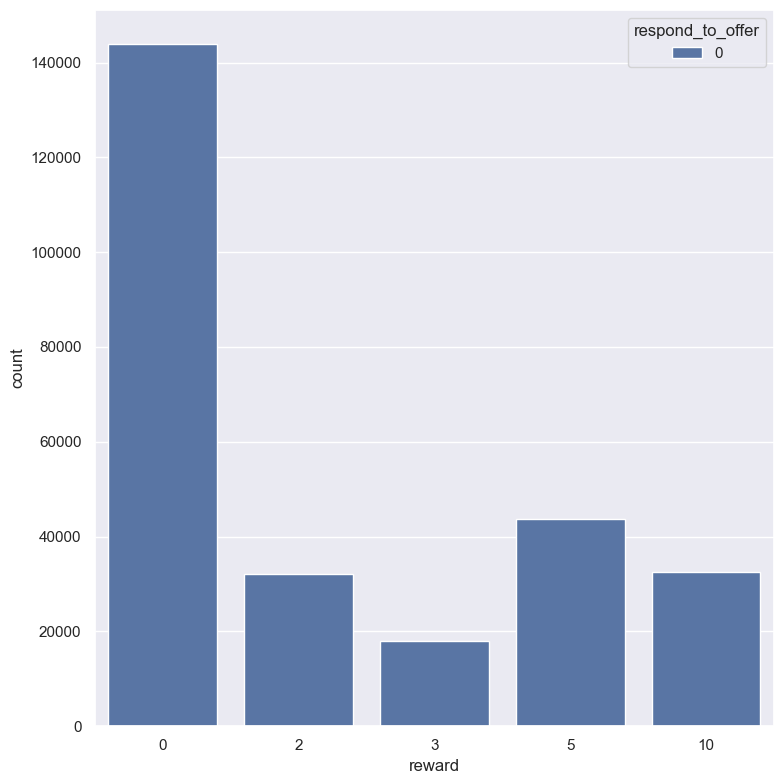

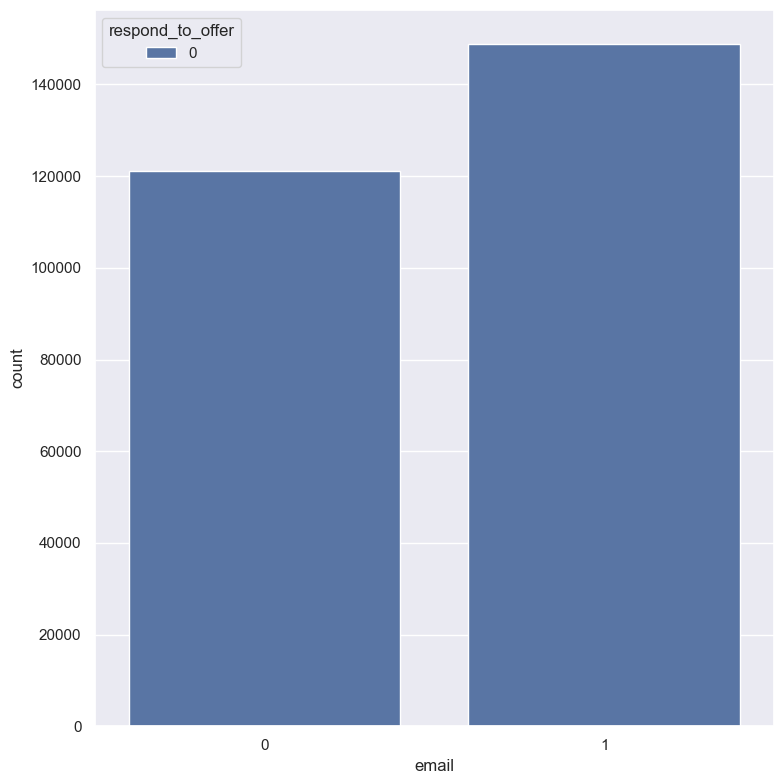

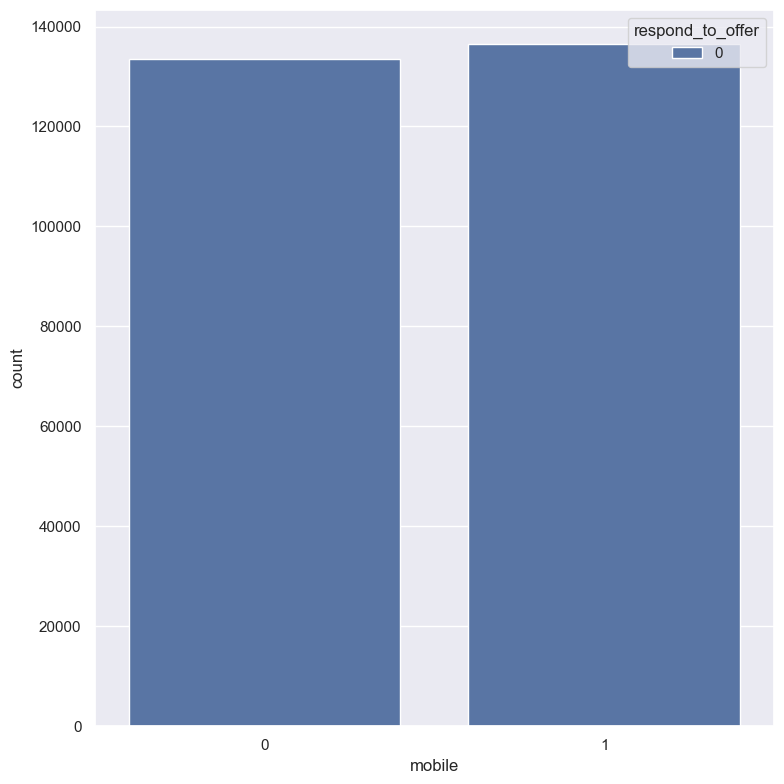

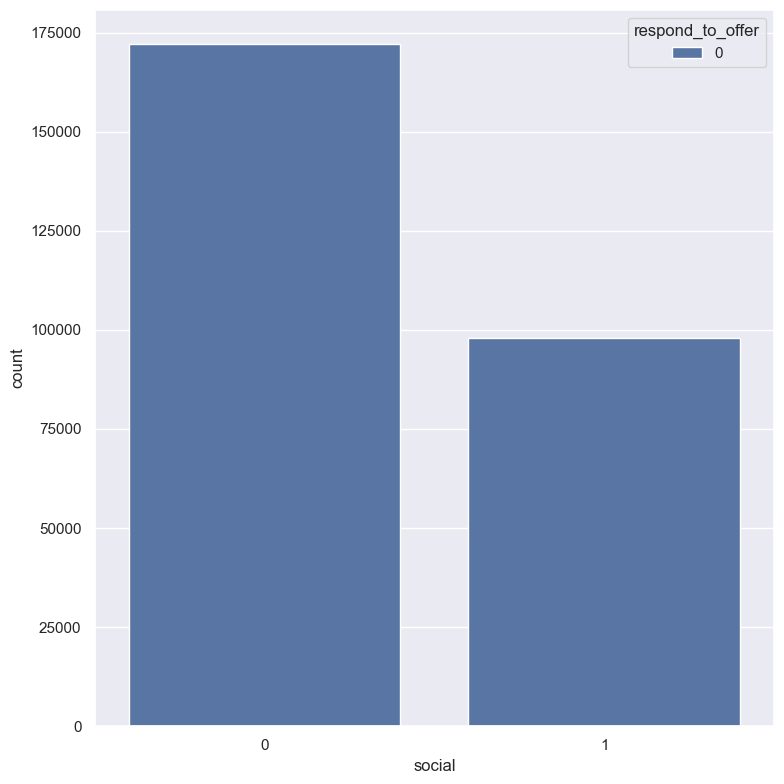

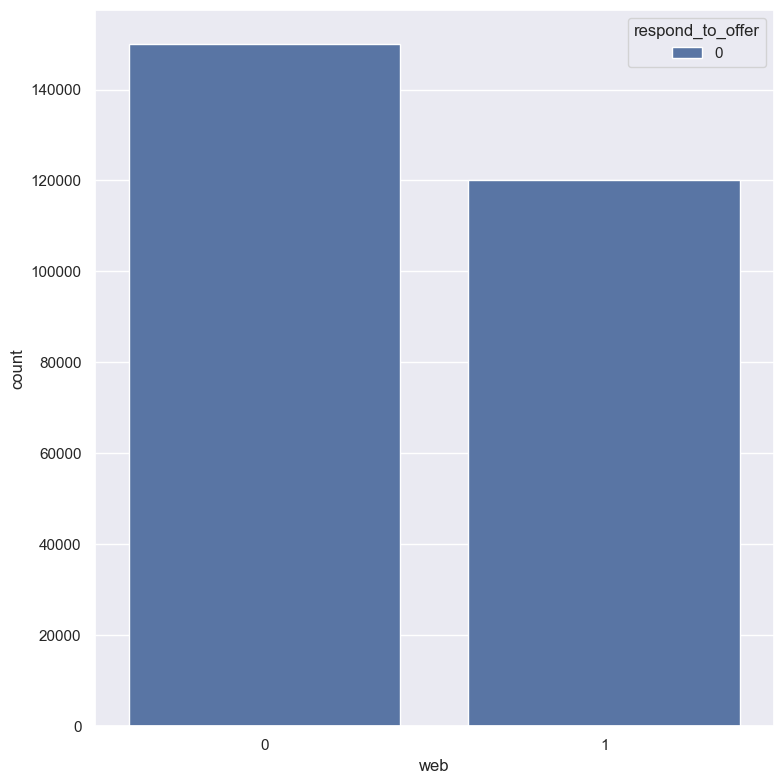

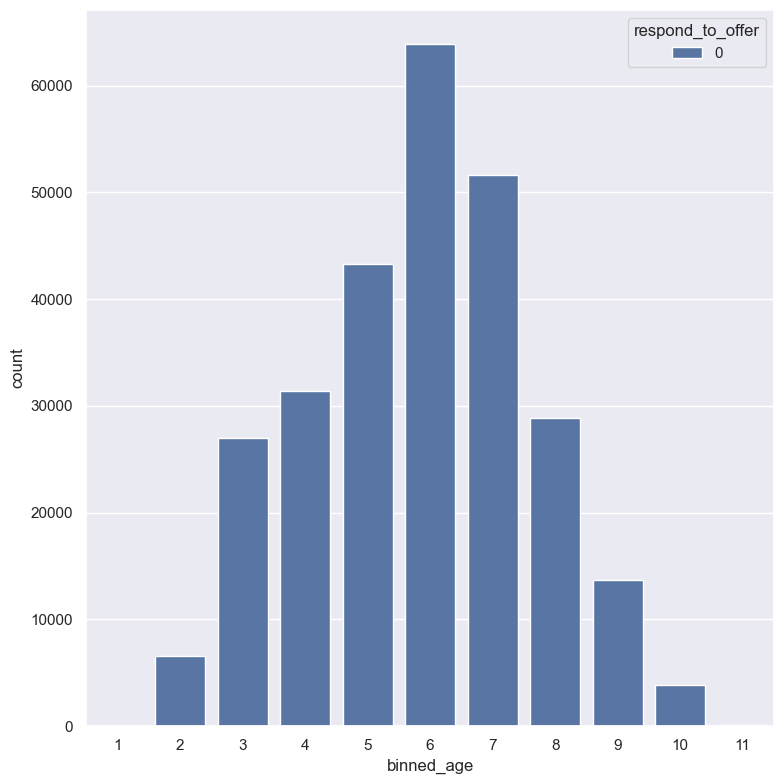

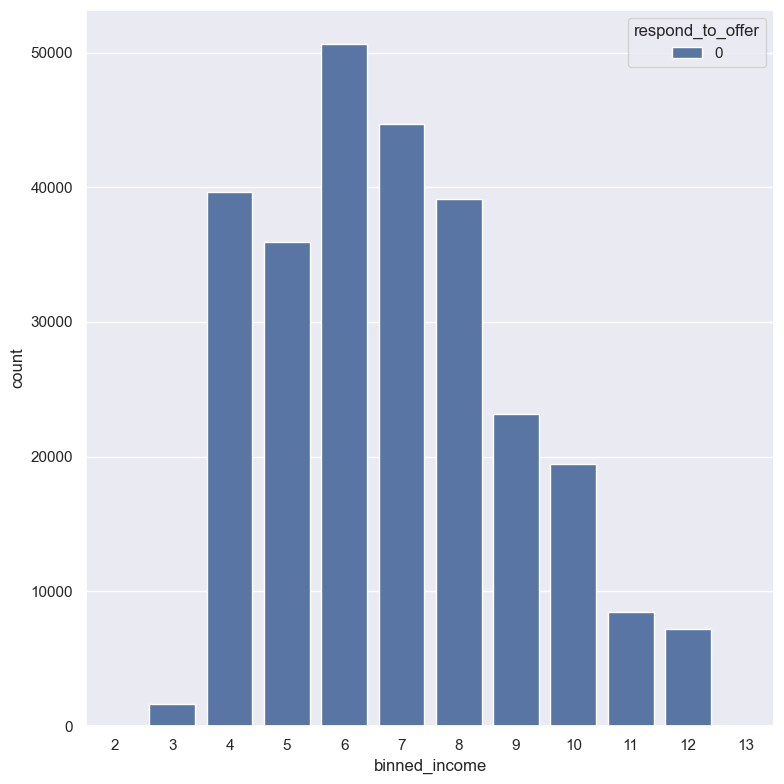

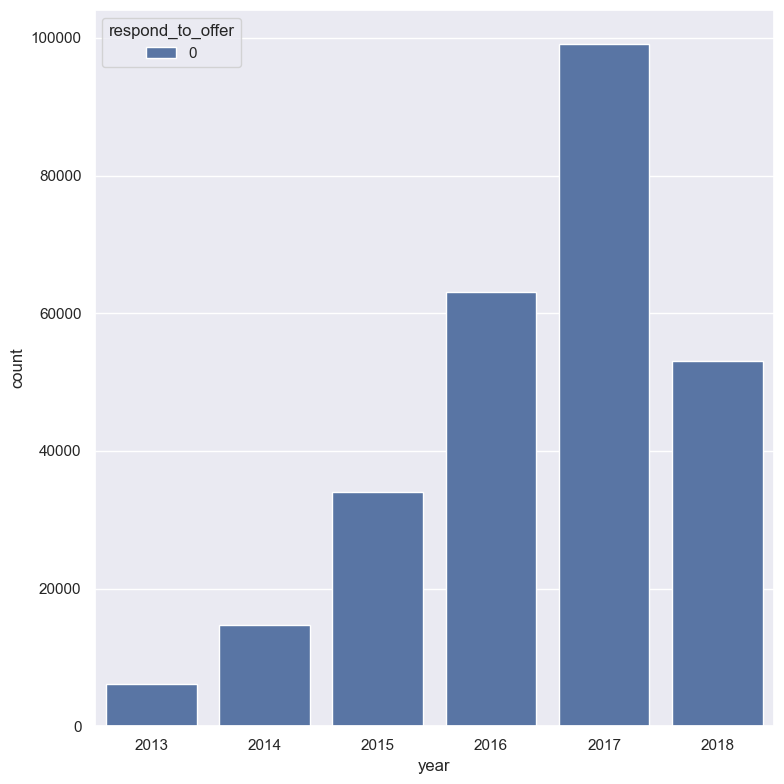

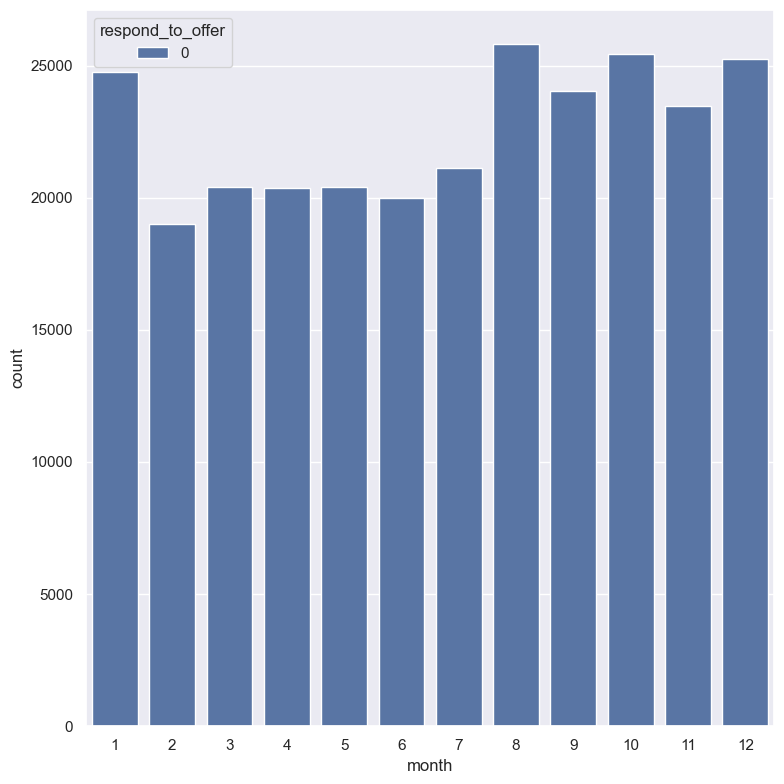

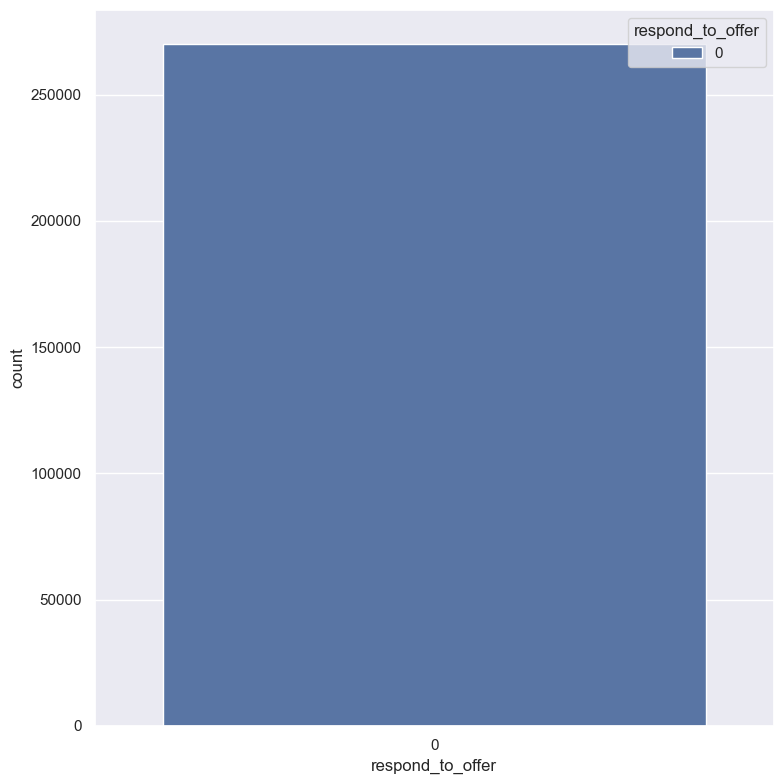

In [178]:
for var in non_mapped_columns:
    temp = df.groupby([var,'respond_to_offer']).size()
    plt.figure(figsize=(8,8))
    sns.countplot(data=df,x=var,hue='respond_to_offer') #, palette=fla
    plt.tight_layout()
    plt.show()

<AxesSubplot:xlabel='gender', ylabel='amount'>

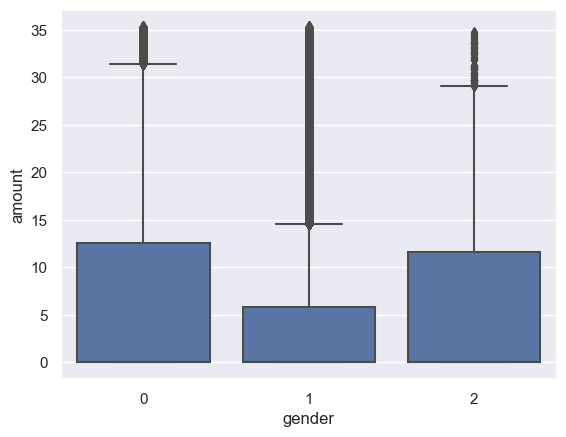

In [179]:
base_color = sns.color_palette()[0]
sns.boxplot(data = df, x = 'gender', y = 'amount', color = base_color)

<AxesSubplot:xlabel='gender', ylabel='time'>

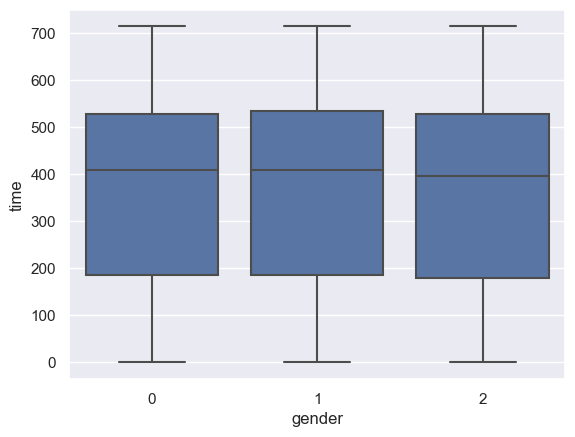

In [180]:
sns.boxplot(data = df, x = 'gender', y = 'time', color = base_color)

<AxesSubplot:xlabel='binned_age', ylabel='amount'>

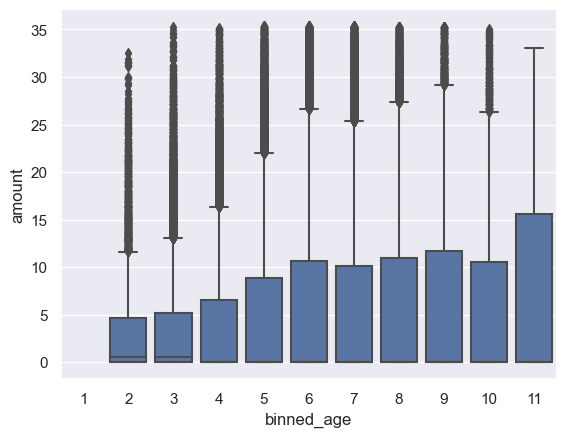

In [181]:
sns.boxplot(data = df, x = 'binned_age', y = 'amount', color = base_color)

<AxesSubplot:xlabel='binned_age', ylabel='time'>

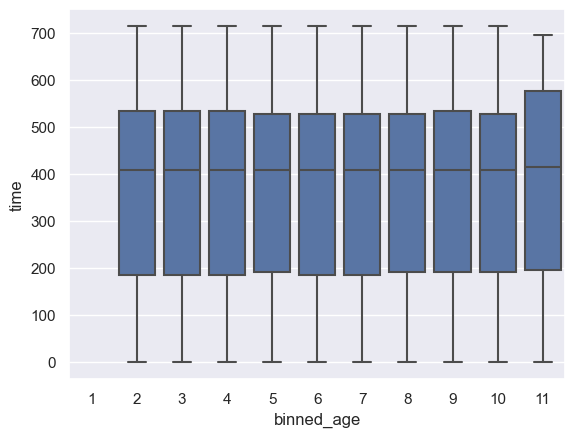

In [182]:
sns.boxplot(data = df, x = 'binned_age', y = 'time', color = base_color)

<AxesSubplot:xlabel='binned_income', ylabel='amount'>

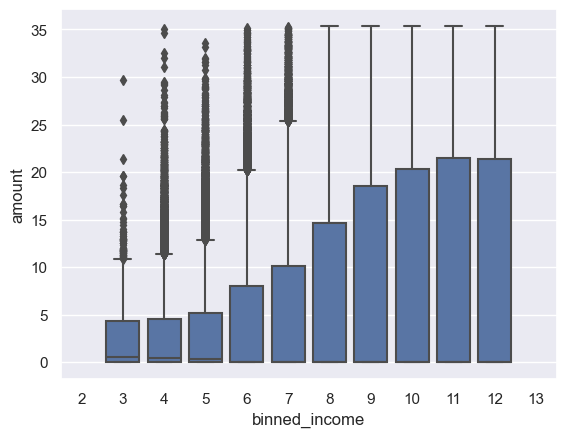

In [183]:
sns.boxplot(data = df, x = 'binned_income', y = 'amount', color = base_color)

<AxesSubplot:xlabel='binned_income', ylabel='time'>

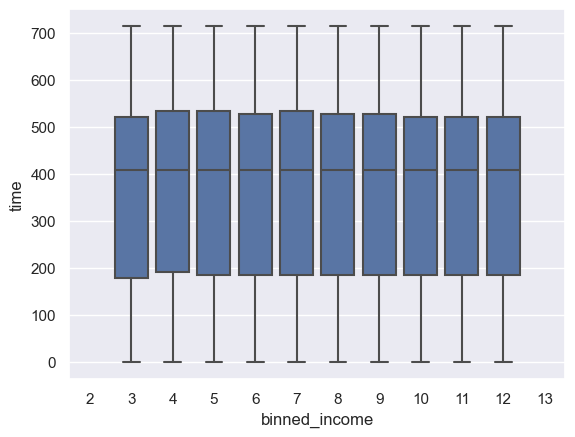

In [184]:
sns.boxplot(data = df, x = 'binned_income', y = 'time', color = base_color)

<AxesSubplot:>

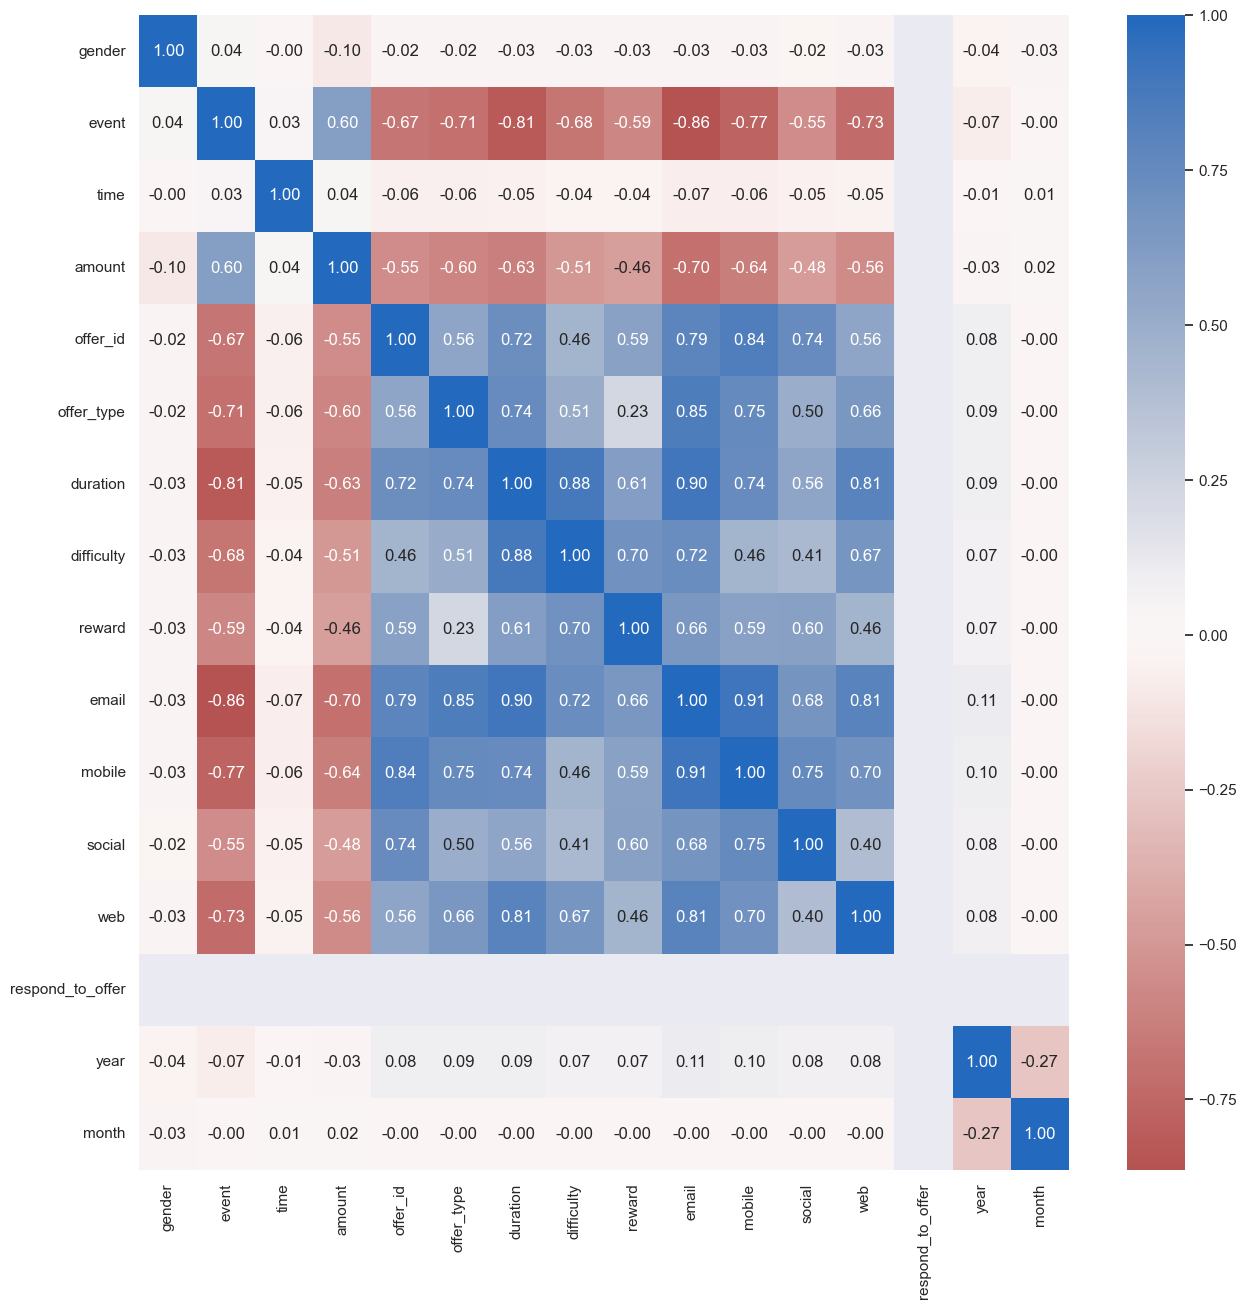

In [185]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), annot = True, fmt = '.2f', cmap = 'vlag_r', center = 0)

<ul>
  <li>event is highly negatively correlated with response_to_offer.</li>
  <li>duration, difficulty, reward, email, moobile, social and web are slightly positively correlated with response_to_offer. </li>
</ul>

 

In [186]:
df.head()

,gender,customer_id,event,time,amount,offer_id,offer_type,duration,difficulty,reward,email,mobile,social,web,respond_to_offer,binned_age,binned_income,year,month
0,0,0610b486422d4921ae7d2bf64640c50b,3,18,21.51,0,0,0,0,0,0,0,0,0,0,6,12,2017,7
1,0,0610b486422d4921ae7d2bf64640c50b,3,144,32.28,0,0,0,0,0,0,0,0,0,0,6,12,2017,7
2,0,0610b486422d4921ae7d2bf64640c50b,1,408,0.00,7,1,7,5,5,1,1,0,1,0,6,12,2017,7
3,0,0610b486422d4921ae7d2bf64640c50b,1,504,0.00,4,3,4,0,0,1,1,0,1,0,6,12,2017,7
4,0,0610b486422d4921ae7d2bf64640c50b,3,528,23.22,0,0,0,0,0,0,0,0,0,0,6,12,2017,7


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


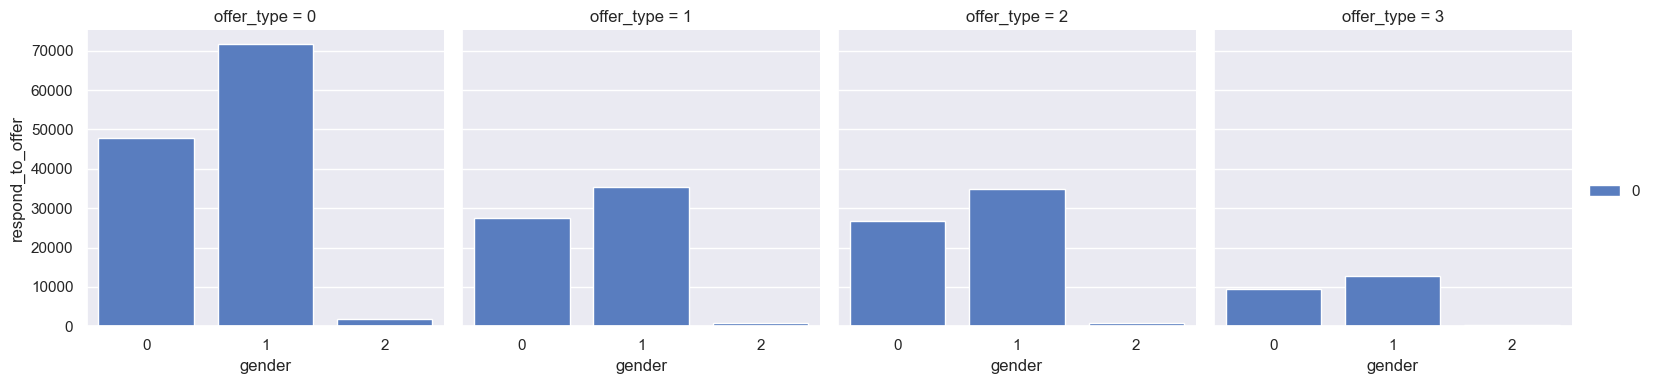

In [187]:
def countplot(x, hue, **kwargs):
    sns.countplot(x=x, hue=hue, **kwargs)

grid = sns.FacetGrid(data=df,col='offer_type',size=4,aspect=1)
fig = grid.map(countplot,'gender','respond_to_offer',palette='muted')
fig.add_legend()

**The percentage of men and women that take advantage of this offer is about same. BOGO and discount offers are generally completed by both of these types of deals.**

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


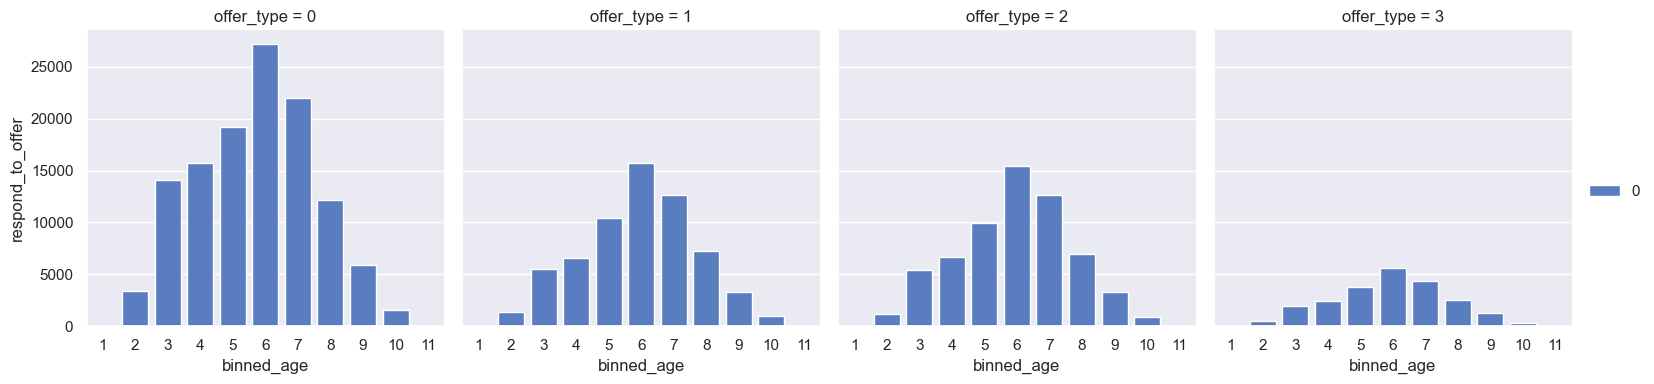

In [188]:
def countplot(x, hue, **kwargs):
    sns.countplot(x=x, hue=hue, **kwargs)

grid = sns.FacetGrid(data=df,col='offer_type',size=4,aspect=1)
fig = grid.map(countplot,'binned_age','respond_to_offer',palette='muted')
fig.add_legend()

* Individuals of all ages have a nearly same reaction to the phrases "BOGO" and "Discount."
* Individuals between the ages of 50 and 60 who take advantage of the offer - Discount most
* Then, people aged 60 to 70 who complete the offer will receive the greatest discount.
* The distribution of responses from customers of all ages, regardless of age group, is practically identical for BOGO and discount offers.
 

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


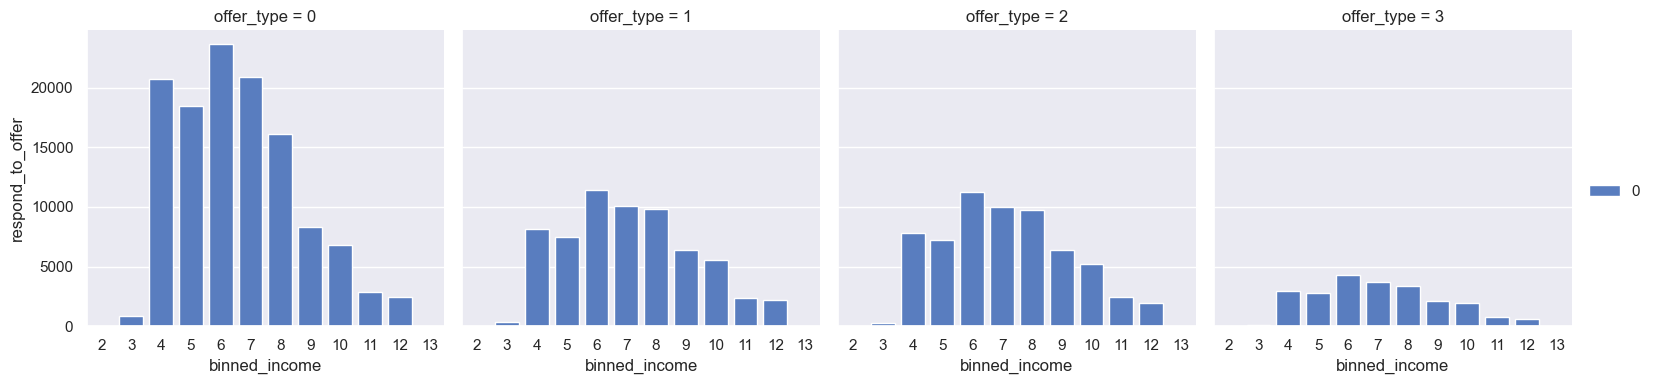

In [189]:
def countplot(x, hue, **kwargs):
    sns.countplot(x=x, hue=hue, **kwargs)

grid = sns.FacetGrid(data=df,col='offer_type',size=4,aspect=1)
fig = grid.map(countplot,'binned_income','respond_to_offer',palette='muted')
fig.add_legend()

**Individuals with incomes between $60,000 and $80,000 are the ones that spend the most money on discounts and buy one get one free deals.**

**Individuals aged 50 to 70 with an annual salary of between $60,000 and $90,000 are the ones who respond most favorably to offers of the BOGO and Discount types.** <br>
**So, it would be beneficial to give these individuals BOGO and discount offers.**

## 4. Model Building 

In [190]:
df.head()

,gender,customer_id,event,time,amount,offer_id,offer_type,duration,difficulty,reward,email,mobile,social,web,respond_to_offer,binned_age,binned_income,year,month
0,0,0610b486422d4921ae7d2bf64640c50b,3,18,21.51,0,0,0,0,0,0,0,0,0,0,6,12,2017,7
1,0,0610b486422d4921ae7d2bf64640c50b,3,144,32.28,0,0,0,0,0,0,0,0,0,0,6,12,2017,7
2,0,0610b486422d4921ae7d2bf64640c50b,1,408,0.00,7,1,7,5,5,1,1,0,1,0,6,12,2017,7
3,0,0610b486422d4921ae7d2bf64640c50b,1,504,0.00,4,3,4,0,0,1,1,0,1,0,6,12,2017,7
4,0,0610b486422d4921ae7d2bf64640c50b,3,528,23.22,0,0,0,0,0,0,0,0,0,0,6,12,2017,7


In [191]:
df.drop(['customer_id', 'offer_id', 'time', 'amount', 'year', 'month'], axis=1, inplace=True)

In [192]:
df.head()

,gender,event,offer_type,duration,difficulty,reward,email,mobile,social,web,respond_to_offer,binned_age,binned_income
0,0,3,0,0,0,0,0,0,0,0,0,6,12
1,0,3,0,0,0,0,0,0,0,0,0,6,12
2,0,1,1,7,5,5,1,1,0,1,0,6,12
3,0,1,3,4,0,0,1,1,0,1,0,6,12
4,0,3,0,0,0,0,0,0,0,0,0,6,12


In [193]:
df.to_csv('data/final.csv', encoding='utf-8', index=False)

In [194]:
y = df['respond_to_offer']
X = df.drop('respond_to_offer', axis=1)

In [239]:
scaler = MinMaxScaler()
normalize_col = list(X.columns)

X[normalize_col] = scaler.fit_transform(X[normalize_col])

In [240]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((216026, 12), (54007, 12), (216026,), (54007,))

In [245]:
X.head()

,gender,event,offer_type,duration,difficulty,reward,email,mobile,social,web,binned_age,binned_income
0,0.0,1.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.444444,1.0
1,0.0,1.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.444444,1.0
2,0.0,0.333333,0.333333,0.7,0.25,0.5,1.0,1.0,0.0,1.0,0.444444,1.0
3,0.0,0.333333,1.000000,0.4,0.00,0.0,1.0,1.0,0.0,1.0,0.444444,1.0
4,0.0,1.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.444444,1.0


In [218]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [238]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import cross_val_score
# from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
classifier = RandomForestClassifier()

In [241]:
# training
classifier.fit(X_train,y_train)

RandomForestClassifier()

In [242]:
y_pred = classifier.predict(X_test)

In [243]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 1.0


In [223]:
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print('\n')

=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     54007

    accuracy                           1.00     54007
   macro avg       1.00      1.00      1.00     54007
weighted avg       1.00      1.00      1.00     54007





## 5. Hyperparameter Tuning 

In [224]:
rfc = RandomForestClassifier()

In [225]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [10,50,100,500,1000]
max_features = ['auto', 'sqrt']

# max depth
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
max_depth.append(None)
# create random grid
random_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
 }

In [226]:
# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid,
                                n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)


In [227]:
# Fit the model
rfc_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [100, 140, 180, 220, 260,
                                                      300, 340, 380, 420, 460,
                                                      500, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [10, 50, 100, 500,
                                                         1000]},
                   random_state=42, verbose=2)

In [228]:
print(rfc_random.best_params_)

{'n_estimators': 1000, 'max_features': 'auto', 'max_depth': 260}


Training Random Forest on best parameters

In [229]:
model = RandomForestClassifier(n_estimators=1000, max_depth=260, max_features='auto')

In [230]:
model.fit(X_train,y_train)

RandomForestClassifier(max_depth=260, n_estimators=1000)

In [231]:
y_pred_final = model.predict(X_test)

In [232]:
print("=== Classification Report ===")
print(classification_report(y_test, y_pred_final))

=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     54007

    accuracy                           1.00     54007
   macro avg       1.00      1.00      1.00     54007
weighted avg       1.00      1.00      1.00     54007



## 6. Conclusion

In general, I found this project to be both interesting and difficult, primarily as a result of the nature of the data. I had began with the business question, and then I developed a machine learning model using Random Forest Classifier with hyperparameter tuning so that I could predict with an accuracy of one whether or not a customer would complete an offer by making a transaction after viewing the offer. It's possible that I'm getting an accuracy of 1 since I'm only taking into account the most crucial qualities and leaving out all of the irrelevant ones.


